<center>
<img src="logo.png" height="900"> 
</center>


# Байесовская домашка

В этом задании мы оценим несколько простых моделей с помощью `pymc3`. 

Задачи делались [на основе книги Байесовские методы для хакеров.](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) В ней вы можете найти ещё больше примеров использования байесовских методов с помощью pymc3. 

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
#!pip install  pymc3

In [4]:
import pymc3 as pm
pm.__version__

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


'3.11.5'

# Упражнение 1 (Маша и медведи)

Помните задачку с вынюхиванием из лекции? Давайте начнём с того, что попробуем решить её в `pymc3`.

__Модель медведя:__ $y_i \sim N(m, 2^2)$

__Априорное мнение, где спряталась Маша:__ $m \sim N(1, 4^2)$

In [5]:
y = np.array([0.5, -1]) # медведи

Задайте априорное распределение и нашу модель.

In [6]:
basic_model = pm.Model()

with basic_model:
    # your code here
    m = pm.Normal('m', mu=1, sigma=4)   
    y_obs = pm.Normal('y_obs', mu=m, sigma=2, observed=y)

Найдите моду апостериорного распределения (байесовские методы для бедных). Запишите результат в переменную `map_estimate`.

In [7]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'m': array(-0.11111111)}

In [8]:
assert np.abs(float(map_estimate['m']) + 0.111111) < 1e-4

# несколько похожих скрытых тестов

Обучите модельс с помощью MCMC, 500 итераций для обучения будет достаточно. 

In [9]:
with basic_model:
    trace = pm.sample(500, return_inferencedata=False, model=basic_model)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 42 seconds.


Найдите вероятность $P(m < 0)$. Ответ запишите в переменную `ans_prob`.

In [10]:
ans_prob = np.mean(trace['m'] < 0)

In [11]:
ans_prob = np.mean(trace['m'] < 0)

In [12]:
assert ans_prob > 0.5

# несколько похожих скрытых тестов

> __Важно:__ перед тем, как отправить тетрадку на проверку, закоментируйте все части кода, где делаются долгие вычисления. На грейдер наложено ограничение в работе в 30 секунд и он может не успеть отработать. Из-за этого задание специфицировано таким образом, что вам нужно получить ответы на вопросы и вбить их в переменные.

# Упражнение 2 (Челленджер)

Байесовский подход - это просто другой способ оценивать те же самые модели. Например, давайте попробуем оценить логистическую регрессию. 

$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [13]:
df = pd.read_csv('challenger.csv', sep=',')
print(df.shape)
df.head()

(23, 3)


,Date,Temperature,Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,01/11/1982,68,0
4,04/04/1983,67,0


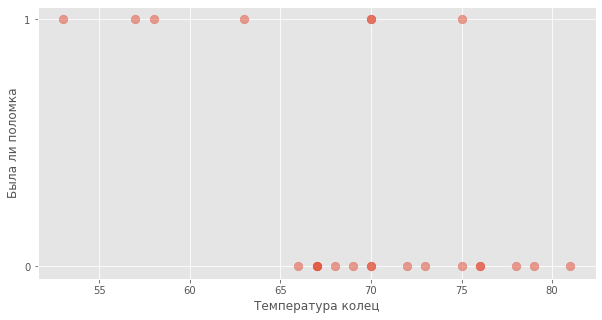

In [14]:
t = df.Temperature.values
y = df.Incident.values

plt.figure(figsize=(10, 5))
plt.scatter(t, y, s=75, alpha=0.5)
plt.yticks([0, 1])

plt.ylabel("Была ли поломка")
plt.xlabel("Температура колец");


Обучим Байесовскую версию логистичесской регресcии.  Модель буде выглядеть следующим образом: 

\begin{equation*}
\begin{aligned}
& \beta \sim N(0, 10^2) \\
& \alpha \sim N(0, 10^2) \\
& p \sim Bern(p) \\
& p = P(y = 1) = \frac{1}{1 + e^{\alpha + \beta \cdot t}}
\end{aligned}
\end{equation*}

In [15]:
import theano.tensor as tt  # под капотом пакета работает theano 
                            # именно на нём прописываются разные сложные формулы

t = df.Temperature.values
y = df.Incident.values

with pm.Model() as model:
    
    beta = pm.Normal('beta', mu=0, sigma=10)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    p = pm.Deterministic("p", 1/(1. + tt.exp(beta*t + alpha)))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

Найдите моду апостериорного распределения (байесовские методы для бедных). Запишите результат в переменную `map_estimate`.

In [16]:
map_estimate = pm.find_MAP(model=model)
map_estimate

{'beta': array(0.16651431),
 'alpha': array(-10.55271333),
 'p': array([0.39240098, 0.2491243 , 0.28155247, 0.31642297, 0.35348731,
        0.19211637, 0.16758631, 0.2491243 , 0.74295758, 0.51557296,
        0.2491243 , 0.0805126 , 0.35348731, 0.84908661, 0.35348731,
        0.12610342, 0.2491243 , 0.05045287, 0.1088663 , 0.06901515,
        0.12610342, 0.1088663 , 0.70989693])}

In [17]:
assert np.abs(float(map_estimate['beta']) - 0.1665) < 1e-2

# несколько похожих скрытых тестов

Попробуем обучить модель немного по-новому. В переменной `step` запишемм конкретный алгоритм, который будем использовать при обучении. В `pm.sapmple` укажем из какой точке надо стартовать алгоритму. В качестве стартовой точки укажем моду апостериорного распределения, полученную в предыдущем пункте. 

In [ ]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=map_estimate)
    burned_trace = trace[100000::10]  # оставляем каждое 10 наблюдение, чтобы соседние наблюдения были менее зависимы

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 2 chains for 1_000 tune and 41_189 draw iterations (2_000 + 82_378 draws total) took 1825 seconds.


Какова вероятность того, что $\beta < 0.0001$? То есть, какова вероятность того, что между температурой и вероятностью поломки нет связи? Запишите овтет в переменную `prob_beta`.

In [26]:
prob_beta = np.mean(trace['beta'] < 0.0001)

In [27]:
assert prob_beta < 0.1

# несколько похожих скрытых тестов

Нарисуем Получившиеся результаты. Для каждой температуры найдем $95\%$ байесовский интервал для вероятности того, что катастрофа произойдёт.

In [ ]:
from scipy.stats.mstats import mquantiles

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t_seq = np.linspace(t.min() - 5, t.max()+5, 50)[:, None]
p_seq = logistic(t_seq.T, burned_trace['beta'][:,None], burned_trace['alpha'][:,None])

mean_prob_t = p_seq.mean(axis=0)
qs = mquantiles(p_seq, [0.025, 0.975], axis=0)

plt.figure(figsize=(10,5))
plt.fill_between(t_seq[:, 0], *qs, alpha=0.7, color="#7A68A6")
plt.plot(t_seq[:, 0], qs[0], label="95% интервал", color="#7A68A6", alpha=0.7)
plt.plot(t_seq, mean_prob_t, lw=1, ls="--", color="k", label="среднее")
plt.legend(loc="lower left")
plt.scatter(t, y, color="k", s=50, alpha=0.5)

plt.xlabel("Температура, $t$")
plt.ylabel("Вероятность поломки");

В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. Найдите апостерионое распределение  вероятности катастрофы. 

In [ ]:
X= logistic(31, x=burned_trace['beta'][:,None], y=burned_trace['alpha'][:,None])

Найдите $5\%$ квантиль, математическое ожидание и $95\%$ квантиль апостериорного распределения. Заишите их в соответствующие переменные. Что это означает в контексте прогноза катастрофы? 

In [ ]:
q05 = np.quantile(X, 0.05)
avg = np.mean(X)
q95 = np.quantile(X, 0.95)

In [ ]:
assert q05  > 0.8

# несколько похожих скрытых тестов

> __Важно:__ перед тем, как отправить тетрадку на проверку, закоментируйте все части кода, где делаются долгие вычисления. На грейдер наложено ограничение в работе в 30 секунд и он может не успеть отработать. Из-за этого задание специфицировано таким образом, что вам нужно получить ответы на вопросы и вбить их в переменные.